2025/05/06 10:10:20 PM, INFO, mealpy.math_based.SCA.DevSCA: Solving single objective optimization problem.
2025/05/06 10:10:23 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 1, Current best: 0.40107913669064743, Global best: 0.40107913669064743, Runtime: 1.09112 seconds
2025/05/06 10:10:24 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 2, Current best: 0.40107913669064743, Global best: 0.40107913669064743, Runtime: 1.08338 seconds
2025/05/06 10:10:25 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 3, Current best: 0.40107913669064743, Global best: 0.40107913669064743, Runtime: 1.33699 seconds
2025/05/06 10:10:26 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 4, Current best: 0.40107913669064743, Global best: 0.40107913669064743, Runtime: 1.09420 seconds
2025/05/06 10:10:27 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 5, Current best: 0.40107913669064743, Global best: 0.40107913669064743, Runtime: 1.16666 second

Graphique sauvegardé: plots/gwo_accuracy_evolution.png

Précision finale: 0.6733

Dataset imputé:
          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0   3.599020  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246  389.490943    592.885359   
2   8.099124  224.236259  19909.541732     9.275884  335.443557    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8   3.129335  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic

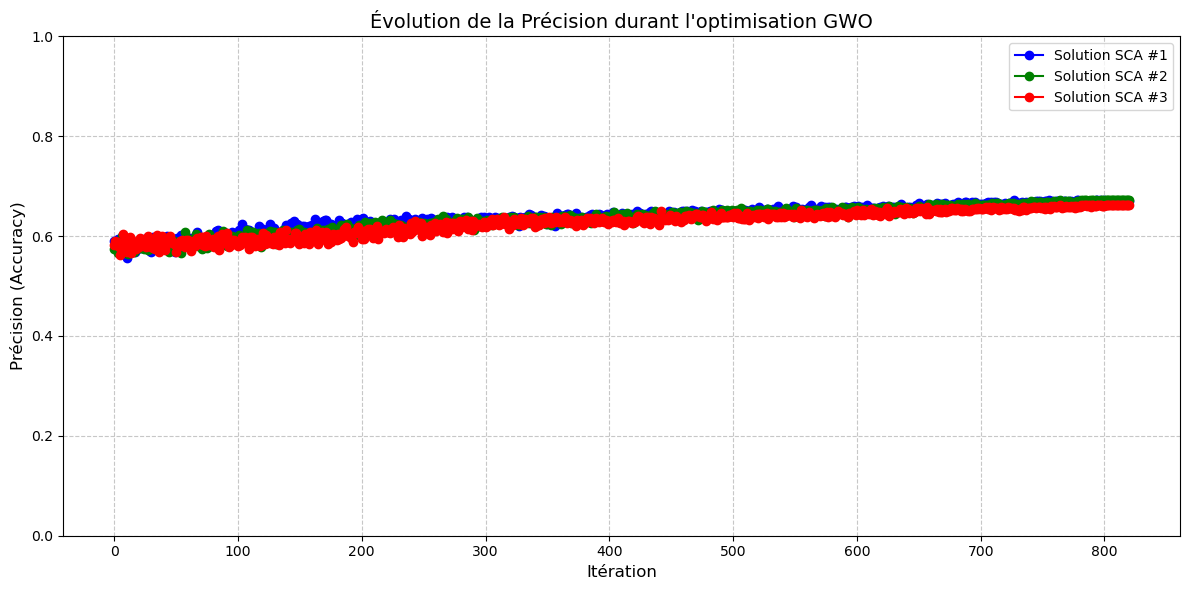

In [4]:
import numpy as np
import pandas as pd
from mealpy import FloatVar, SCA, GWO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

def sca_gwo_hybrid(data_path, testingset=0.2, epoch=50, popsize=30, gwo_epoch=40, gwo_popsize=20, save_plots=True, output_dir="plots"):
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Charger les données
    df = pd.read_csv(data_path)
    data = df.values
    
    scaler = StandardScaler()
    
    features = data[:, 0:9]  
    target = data[:, 9]   
    
    scaler.fit(features)
    features = scaler.transform(features)
    
    accuracies = []
    f1_scores = []
    sca_iteration_accuracies = []
    gwo_iteration_accuracies = {}
    
    # Identifier NaN values
    nan_indices = np.array([
        (row, col)
        for col in range(features.shape[1])
        for row in np.argwhere(np.isnan(features[:, col])).flatten()
    ])
    
    nan_n = np.sum(np.isnan(features))
    
    # no imputation if no NaN values
    if nan_n == 0:
        print("Aucune valeur manquante à imputer.")
        return df, {}
    
    # Séparer les données avec et sans NaN
    nan_mask = ~np.isnan(features).any(axis=1)
    features_without_nan = features[nan_mask].copy()
    
    lb = (np.min(features_without_nan), ) * nan_n
    ub = (np.max(features_without_nan), ) * nan_n
    
    original_indices_of_without_nan = np.where(nan_mask)[0]
    original_indices_of_nan = np.where(~nan_mask)[0]
    
    features_without_nan = features[original_indices_of_without_nan,:]
    target_without_nan = target[original_indices_of_without_nan]
    
    X_train, X_test, y_train, y_test = train_test_split(
        features_without_nan, target_without_nan, test_size=testingset, random_state=42
    )
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    sca_solutions = []
    
    def sca_objective_function(solution):
        features_copy = features.copy()
        
        for k, (row, col) in enumerate(nan_indices):
            features_copy[row, col] = solution[k]
        
        X_test_solution = np.concatenate((features_copy[original_indices_of_nan, :], X_test), axis=0)
        y_test_solution = np.concatenate((target[original_indices_of_nan], y_test), axis=0)
        
        y_pred = knn.predict(X_test_solution)
        
        acc = accuracy_score(y_test_solution, y_pred)
        f1 = f1_score(y_test_solution, y_pred)
        
        sca_solutions.append((solution, acc, f1))
        sca_iteration_accuracies.append(acc)
        
        if len(accuracies) == 0 or max(accuracies) < acc:
            accuracies.append(acc)
        
        if len(f1_scores) == 0 or max(f1_scores) < f1:
            f1_scores.append(f1)
            
        fitness = 1 - acc
        return fitness
    
    def gwo_objective_function(solution, solution_id):
        if solution_id not in gwo_iteration_accuracies:
            gwo_iteration_accuracies[solution_id] = []
            
        features_copy = features.copy()
        
        for k, (row, col) in enumerate(nan_indices):
            features_copy[row, col] = solution[k]
        
        X_test_solution = np.concatenate((features_copy[original_indices_of_nan, :], X_test), axis=0)
        y_test_solution = np.concatenate((target[original_indices_of_nan], y_test), axis=0)
        
        y_pred = knn.predict(X_test_solution)
        
        acc = accuracy_score(y_test_solution, y_pred)
        f1 = f1_score(y_test_solution, y_pred)
        
        gwo_iteration_accuracies[solution_id].append(acc)
        
        if len(accuracies) == 0 or max(accuracies) < acc:
            accuracies.append(acc)
        
        if len(f1_scores) == 0 or max(f1_scores) < f1:
            f1_scores.append(f1)
            
        fitness = 1 - acc
        return fitness
    
    problem_dict = {
        "bounds": FloatVar(lb=lb, ub=ub, name="delta"),
        "minmax": "min",
        "obj_func": sca_objective_function
    }
    
    model_sca = SCA.DevSCA(epoch=epoch, pop_size=popsize)
    g_best_sca = model_sca.solve(problem_dict)
    
    sca_solutions.sort(key=lambda x: x[1], reverse=True)
    top_solutions = sca_solutions[:min(3, len(sca_solutions))]
    
    best_gwo_solution = None
    best_gwo_fitness = float('inf')
    
    # Appliquer GWO sur chaque solution SCA
    for idx, (sca_solution, acc, f1) in enumerate(top_solutions):
        solution_id = f"solution_{idx+1}"
        
        def objective_wrapper(solution):
            return gwo_objective_function(solution, solution_id)
        
        problem_dict_gwo = {
            "bounds": FloatVar(lb=lb, ub=ub, name="delta"),
            "minmax": "min",
            "obj_func": objective_wrapper
        }
        
        model_gwo = GWO.OriginalGWO(epoch=gwo_epoch, pop_size=gwo_popsize)
        g_best_gwo = model_gwo.solve(problem_dict_gwo)
        
        if g_best_gwo.target.fitness < best_gwo_fitness:
            best_gwo_fitness = g_best_gwo.target.fitness
            best_gwo_solution = g_best_gwo.solution
    
    # best GWO on the dataset
    features_final = features.copy()
    for k, (row, col) in enumerate(nan_indices):
        features_final[row, col] = best_gwo_solution[k]
    
    features_final = scaler.inverse_transform(features_final)
    df_imputed = df.copy()
    
    for col in range(features.shape[1]):
        col_name = df.columns[col]
        for row in np.argwhere(np.isnan(features[:, col])).flatten():
            df_imputed.loc[row, col_name] = features_final[row, col]
    
    if save_plots:
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'green', 'red']
        for i, solution_id in enumerate(gwo_iteration_accuracies.keys()):
            if i < len(colors):
                color = colors[i]
            else:
                color = 'gray'
            plt.plot(gwo_iteration_accuracies[solution_id], color=color, marker='o', 
                     label=f'Solution SCA #{i+1}')
        
        plt.title('Évolution de la Précision durant l\'optimisation GWO', fontsize=14)
        plt.xlabel('Itération', fontsize=12)
        plt.ylabel('Précision (Accuracy)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylim([0, 1])
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/gwo_accuracy_evolution.png", dpi=300)
        print(f"Graphique sauvegardé: {output_dir}/gwo_accuracy_evolution.png")
    
    return df_imputed, {
        "final_accuracy": 1 - best_gwo_fitness,
        "sca_accuracy_evolution": sca_iteration_accuracies,
        "gwo_accuracy_evolution": gwo_iteration_accuracies
    }

if __name__ == "__main__":
    df_imputed, results = sca_gwo_hybrid("water_potability.csv", save_plots=True)
    print(f"\nPrécision finale: {results['final_accuracy']:.4f}")
    print("\nDataset imputé:")
    print(df_imputed.head(10))  